# Land Carbon Sink Analysis

Main notebook for the Land Carbon Sink Analysis project.

In [3]:
# import requirements

import polars as pl
import xarray as xr
import geopandas as gpd
import matplotlib
import rioxarray as rxr
from rasterio.features import geometry_mask
# import xesmf as xe
import numpy as np

In [4]:
# directories
rawDir = "../data/raw/"
interimDir = "../data/interim/"
processedDir = "../data/processed/"

## Net Land-use Flux

In [5]:
# National land use change carbon emissions ['Summary', 'BLUE', 'H&C2023', 'OSCAR']
nluc = pl.read_excel(
    rawDir + "National_LandUseChange_Carbon_Emissions_2023v1.0.xlsx",
    sheet_id=2,
    read_options={"header_row": 7},
    has_header=0,
)
nluc.head()

unit: Tg C/year,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burkina Faso,Burundi,Cambodia,Cameroon,Canada,Cape Verde,Central African Republic,Chad,Chile,China,…,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Tajikistan,Thailand,Timor-Leste,Togo,Tonga,Trinidad and Tobago,Tunisia,Türkiye,Turkmenistan,Tuvalu,Uganda,Ukraine,United Arab Emirates,United Kingdom,Tanzania,USA,Uruguay,Uzbekistan,Vanuatu,Vatican City,Venezuela,Viet Nam,Yemen,Zambia,Zimbabwe,OTHER,DISPUTED,Global,EU27
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""QF""",1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,…,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
"""1850""",0.81321,0.35006,1.3491,0.0056,2.42807,-0.00222,3.15928,0.17596,2.41452,1.08449,0.85176,0.0006,0.0,4.81875,0.01646,10.81258,1.24621,0.04652,-1.36558,0.13964,7.03278,1.02102,0.08413,11.24974,0.01408,1.15645,0.13244,0.45949,0.33528,0.94758,19.73677,0.00653,0.30411,2.38661,2.50938,64.75003,…,1.31066,8.25594,6.39086,0.41039,0.05917,6.33314,1.01622,0.2111,0.14773,5.44597,0.52221,0.13251,0.00669,0.29177,0.13148,4.05924,0.14281,0,1.5229,13.7545,-0.0002,2.32986,2.37006,220.15201,0.24275,0.52615,0.01398,0.00001,13.8727,5.1552,-0.15362,2.8091,0.22792,0.01569,0.42685,989.03703,95.33341
"""1851""",0.81928,0.36496,1.32128,0.00473,2.42977,-0.00393,3.28472,0.17582,2.71252,1.06181,0.84572,0.00064,0.0,4.02972,0.0154,10.822,1.24206,0.10955,-1.37469,0.32481,10.14895,1.00515,0.08423,12.22678,-0.01237,1.05056,0.13652,0.45413,0.30871,0.82311,19.80653,0.00665,0.28336,3.79434,2.58041,64.37465,…,1.30551,7.75396,5.93256,0.39427,0.05801,6.38944,1.00094,0.21172,0.14892,6.93277,0.56196,0.12506,0.00659,0.26722,0.13673,4.06812,0.14422,0,1.37743,14.9705,-0.00021,1.56048,2.12809,236.7311,0.35285,0.53124,0.0078,0.00001,16.91828,5.45471,-0.15613,2.70464,0.22459,0.01461,0.61147,1039.62828,93.85074
"""1852""",0.82466,0.3788,1.30517,0.00415,2.46422,-0.00547,3.29216,0.17614,2.96212,1.05418,0.84089,0.00068,0.0,3.77321,0.01485,10.86556,1.17393,0.06239,-1.38575,0.16973,11.98688,1.02707,0.08418,10.64325,-0.0038,0.98014,0.13494,0.45724,0.28953,0.57793,22.80865,0.00672,0.22063,4.72838,2.64438,62.24161,…,1.30136,7.47281,5.64669,0.38996,0.05898,6.4624,1.00337,0.21186,0.14976,7.66162,0.5831,0.11461,0.00642,0.25655,0.1399,4.07304,0.14505,0,1.3259,15.88161,-0.00022,0.70421,2.03147,244.76757,0.45218,0.53449,0.00644,0.00001,17.99017,5.15271,-0.15834,2.76771,0.22112,0.01433,0.36787,1065.75318,93.05538
"""1853""",0.82924,0.38932,1.29503,0.00369,2.47617,-0.00688,3.31606,0.17661,3.09466,1.04186,0.83819,0.00069,0.0,3.65993,0.01448,10.80604,1.27642,0.17646,-1.39734,0.17814,13.33429,1.0499,0.08406,11.33311,0.00137,0.92497,0.13092,0.43305,0.2924,0.61655,24.19316,0.00675,0.21442,5.41144,2.75901,61.85008,…,1.29812,7.27195,5.45361,0.3805,0.05794,6.49285,1.04869,0.21176,0.15027,7.1364,0.60121,0.10331,0.0063,0.2513,0.14196,4.07067,0.14559,0,1.28171,16.57404,-0.00023,0.43365,1.96437,256.98638,0.52857,0.53678,0.00631,0.00001,19.47363,5.43101,-0.16043,2.75974,0.23146,0.01406,0.46614,1094.90553,92.06626


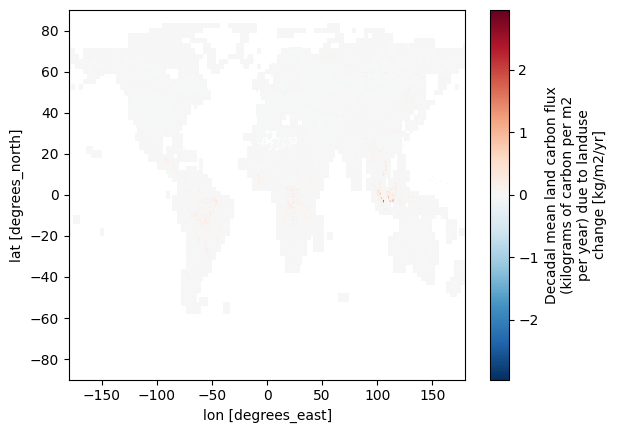

In [6]:
# Land use change carbon emissions (0.25 arcdegrees)
lucGrid = xr.open_dataset(rawDir + "Landuse_carbon_flux_gridded_GCB2023_2013-2022_mean.nc")
lucGrid.Landuse_Cflux.plot()

## Natural Land Sink

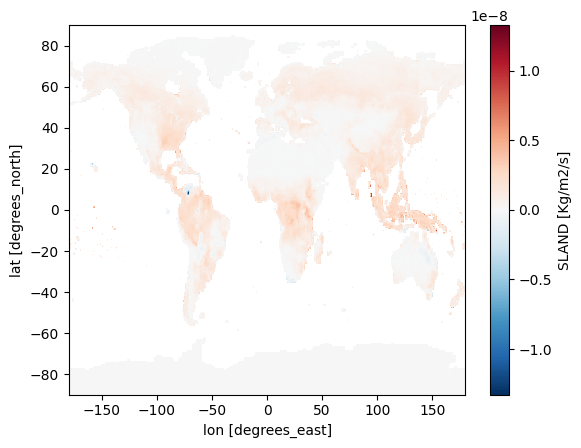

In [7]:
# Natural Land Sink (0.5 arcdegrees)
natLandSink = xr.open_dataset(rawDir + "Land_carbon_uptake_DGVMs_gridded_GCB2023_2013-2022_mean.nc")
natLandSink.SLAND.plot()

### Regrid Natural Land Sink to 0.25 arcdegrees

In [8]:
(natLandSink['lat'].max() - natLandSink['lat'].min())/(natLandSink['lat'].count()-1.)
(natLandSink['lon'].max() - natLandSink['lon'].min())/(natLandSink['lon'].count()-1.)

<xarray.DataArray 'lon' ()> Size: 8B
array(0.5)

In [9]:
# ds_out = xe.util.grid_2d(-180.0, 180.0, 0.25, -90.0, 90.0, 0.25)
# regridder = xe.Regridder(natLandSink, ds_out, 'bilinear', periodic=True)
# natLandSink_025deg = regridder(natLandSink['SLAND'])

In [ ]:
# Clip data to countries and calculate values

countries  = gpd.read_file()

for idx, country in countries.iterrows():
    geom = country['geometry']
    mask = geometry_mask([geom], transform=natLandSink.rio.transform(), invert=True, out_shape=natLandSink.shape)
    
    clipped_data = natLandSink.where(~mask)  # Invert mask to keep values within the geometry

    # Sum of values
    country_sum = clipped_data.sum().values
    

## Fossil and Industry CO2 emissions

## Inclusive Wealth Calculations

### Country Social Cost of Carbon

In [10]:
cscc = pl.read_csv(
    rawDir
    + "statscc_SSP2_rcp60_constant_estimates_climensemble_hmqrs_lineartrend.csv",
    null_values=["NA"],
)

cscc.head()

mean,10%,25%,50%,75%,90%,ID,iso,dr,elasmu,prtp
f64,f64,f64,f64,f64,f64,str,str,str,str,i64
0.005771,0.002139,0.00311,0.004218,0.007508,0.01243,"""2_1p5_NA_AFG""","""AFG""",null,"""1p5""",2
0.193915,0.146453,0.161908,0.185704,0.224977,0.246136,"""2_1p5_NA_AGO""","""AGO""",null,"""1p5""",2
0.003214,0.001607,0.002301,0.002832,0.004133,0.005066,"""2_1p5_NA_ALB""","""ALB""",null,"""1p5""",2
0.899642,0.671506,0.71822,0.820168,1.066469,1.239778,"""2_1p5_NA_ARE""","""ARE""",null,"""1p5""",2
0.207296,0.1013,0.159885,0.200887,0.264989,0.304651,"""2_1p5_NA_ARG""","""ARG""",null,"""1p5""",2
